In [2]:
import os
import json
import random
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

## Code to use boxes with NaN values

In [44]:
# product, time_reso = 'IMERG', '1dy'
product, time_reso = 'CHIRPS', '1dy'
# product, time_reso = 'GSMaP', '3h'

In [ ]:
yy_s, yy_e = 2002, 2012

# # Coast area to CHIRPS
lon_min, lon_max, lat_min, lat_max, area, toll = 12, 12.5, 45.3, 45.5, 'COAST', 0.05
# # Test area 1
# lon_min, lon_max, lat_min, lat_max, area, toll = 11.5, 12, 45.5, 46, 'FAST', 0.05
# # Test area 2
# lon_min, lon_max, lat_min, lat_max, area, toll = 11, 12.5, 45, 46.5, 'TEST', 0.05
# # Veneto
# lon_min, lon_max, lat_min, lat_max, area, toll = 10.5, 13.5, 44.5, 47, 'VENETO', 0.002

In [46]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CHIRPS_1dy.json
Number of threads: 22
Neighborhood area: 5x5



In [47]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [48]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    VENETO_DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_1000.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [49]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat']
lons = PRE_data['lon']

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: CHIRPS_Italy_1dy_1981_01_01_2024_06_30.nc


<xarray.Dataset> Size: 145MB
Dimensions:  (time: 4018, lat: 90, lon: 100)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float32 360B 43.52 43.57 43.62 43.67 ... 47.87 47.92 47.97
  * lon      (lon) float32 400B 9.525 9.575 9.625 9.675 ... 14.38 14.43 14.47
Data variables:
    PRE      (time, lat, lon) float32 145MB ...
Attributes:
    description:  CHIRPS daily data for Italy region

In [50]:
# Extracting lat and lon points for Study area (VENETO)
sat_list_ = ['MSWEP', 'PERSIANN', 'SM2RAIN', 'ERA5', 'GSMaP']
if product in sat_list_:
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

# del ds_veneto

In [51]:
PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

In [177]:
lat_c = lats[ndices_lat[18]].values
lon_c = lons[ndices_lon[41]].values

In [178]:
box3 = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 3)
box3_lon2d, box_3_lat2d = np.meshgrid(box3['lon'].values, box3['lat'].values)

lat_mask = lats.isin(box3['lat'].values)
lon_mask = lons.isin(box3['lon'].values)

box3_mask = xr.DataArray(np.outer(lat_mask, lon_mask),
                    coords={'lat': lats, 'lon': lons},
                    dims=['lat', 'lon'])

print(f'Box ART: {box3['PRE'].shape}')

Box ART: (4018, 7, 7)


In [179]:
box3_lon2d, box3_lat2d = np.meshgrid(box3['lon'],box3['lat'])

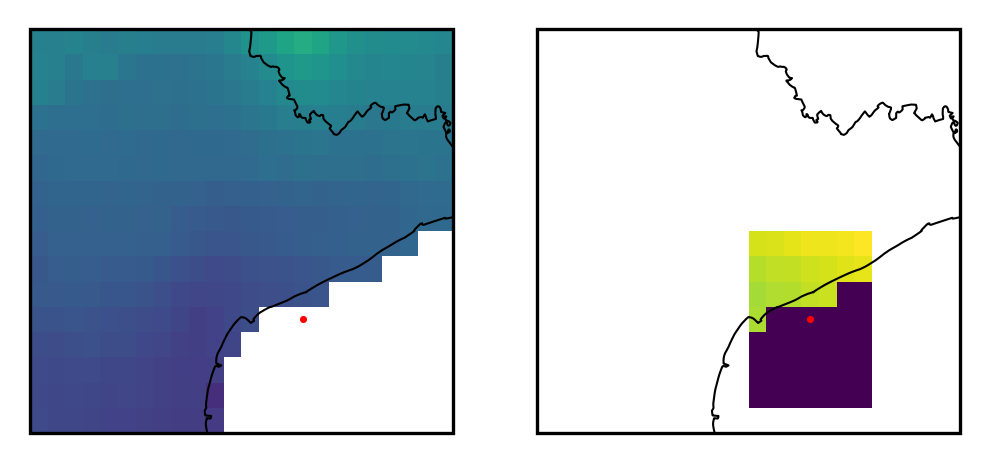

In [180]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# =====================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
ax1.set_extent([11.8, 13, 45.2, 46],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.pcolormesh(lon2d, lat2d, np.mean(PRE_daily['PRE'].values,axis=0))
ax1.scatter(lon_c,lat_c,s=0.5,c='r')

# =====================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([12.4, 12.7, 45.3, 45.7],crs=proj)
ax1.set_extent([11.8, 13, 45.2, 46],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.pcolormesh(box3_lon2d, box3_lat2d,box3['PRE'].sum(dim='time'))
ax1.scatter(lon_c,lat_c,s=0.5,c='r')

In [164]:
all_nan_mask = box3['PRE'].isnull().all(dim='time')
has_fully_nan_series = all_nan_mask.any()

if has_fully_nan_series == True:
    print('Excluir')
else:
    print('Downscale process')

Excluir


In [189]:
all_nan_mask = box3['PRE'].isnull().all(dim='time')
num_all_nan_pixels = all_nan_mask.sum().item()  # cuántos son True
total_pixels = all_nan_mask.size
nan_ratio = num_all_nan_pixels / total_pixels

print(f'Ratio: {nan_ratio}')

if nan_ratio < 0.5:
    print('Downscale process')
else:
    print('Excluir')

Ratio: 0.5918367346938775
Excluir


In [188]:
num_all_nan_pixels,total_pixels

(29, 49)